# Importing Packages

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
import imageio

In [2]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from customMetrics import dice_loss, dice_coef, iou

In [22]:
from gammaTransformation import transform_adaimg

In [3]:
from sklearn.metrics import confusion_matrix

In [4]:
from patchify import patchify, unpatchify

In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Loading Utils Functions

In [6]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [7]:
def read_image(path):
    src = cv2.imread(path, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    x = cv2.cvtColor(transform_adaimg(rgb), cv2.COLOR_RGB2BGR)
    
    top, bottom = [28] * 2
    left, right = [37,38]
    
    x = cv2.copyMakeBorder(x, top, bottom, left, right, cv2.BORDER_CONSTANT, value= 0)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

In [8]:
def read_gt(path):
    x = imageio.mimread(path)[0]  ## (128, 128)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

In [9]:
def load_data(path):
    x = sorted(glob(os.path.join(path, "images", "*.tif")))
    y = sorted(glob(os.path.join(path, "1st_manual", "*.gif")))
    return x, y

In [10]:
def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    cat_images = np.concatenate([ori_y, line, y_pred], axis=1)
    
    cv2.imwrite(save_image_path, cat_images)

In [11]:
def save_tests(y_pred, save_image_path):

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255


    cv2.imwrite(save_image_path, y_pred)

In [12]:
def get_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    sen = tp/(tp+fn)
    spe = tn/(tn+fp) 
    return sen, spe

# Setting The Environment

In [13]:
H = 584
W = 565

In [14]:
data_path = "D:\\Data sets\\DRIVE"

In [15]:
""" Save the results in this folder """
create_dir("results")

In [34]:
""" Load the model """
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("modelDir/model128_2.h5")


In [35]:
""" Load the dataset """
traindataset_path = os.path.join(data_path,"training")
train_x, train_y = load_data(traindataset_path)

testdataset_path = os.path.join(data_path,"test")
test_x, test_y = load_data(testdataset_path)

In [36]:
testdataset_path,len(test_x)

('D:\\Data sets\\DRIVE\\test', 20)

In [37]:
traindataset_path,len(train_x)

('D:\\Data sets\\DRIVE\\training', 20)

In [38]:
from matplotlib import pyplot as plt

In [46]:
""" Make the prediction and calculate the metrics values """
SCORE = []

for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    
    """ Extracting name """
    name = x.split("\\")[-1].split(".")[0]
    print(name)
    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_gt(y)
    
    print(ori_x.shape, ori_y.shape)
    
    patches_img = patchify(x, (128, 128,3), step=128)
    
    pred_patches = []
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):        
            single_patch_img = patches_img[i,j,:,:][0]
#             print(single_patch_img.shape)
            
            """ Prediction """
            y_pred = model.predict(np.expand_dims(single_patch_img, axis=0))[0]
            y_pred = y_pred > 0.5
            y_pred = y_pred.astype(np.int32)
            y_pred = np.squeeze(y_pred, axis=-1)
            
            pred_patches.append(y_pred)
    pred_patches_reshaped = np.reshape(pred_patches, (5, 5, 128,128) )
    reconstructed_image = unpatchify(pred_patches_reshaped, (640,640))
    
    final_y_pred = reconstructed_image[28:-28,37:-38]
    print(final_y_pred.shape)
#     plt.imshow(final_y_pred, cmap='gray')
    
    
    """ Saving the images """
    save_image_path = f"results\\{name}Test.png"
    print(save_image_path)

    save_results(ori_x, ori_y, final_y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    final_y_pred = final_y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, final_y_pred)
    f1_value = f1_score(y, final_y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, final_y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, final_y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, final_y_pred, labels=[0, 1], average="binary")
    
    cm = confusion_matrix(y, final_y_pred)
    sensitivity, specificity = get_metrics(cm)
    
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, sensitivity, specificity])

  0%|                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

01_test
(640, 640, 3) (584, 565)
(584, 565)
results\01_testTest.png


  5%|███████▎                                                                                                                                         | 1/20 [00:02<00:49,  2.59s/it]

02_test
(640, 640, 3) (584, 565)
(584, 565)
results\02_testTest.png


 10%|██████████████▌                                                                                                                                  | 2/20 [00:04<00:43,  2.40s/it]

03_test
(640, 640, 3) (584, 565)
(584, 565)
results\03_testTest.png


 15%|█████████████████████▊                                                                                                                           | 3/20 [00:07<00:41,  2.44s/it]

04_test
(640, 640, 3) (584, 565)
(584, 565)
results\04_testTest.png


 20%|█████████████████████████████                                                                                                                    | 4/20 [00:10<00:40,  2.53s/it]

05_test
(640, 640, 3) (584, 565)
(584, 565)
results\05_testTest.png


 25%|████████████████████████████████████▎                                                                                                            | 5/20 [00:13<00:41,  2.80s/it]

06_test
(640, 640, 3) (584, 565)
(584, 565)
results\06_testTest.png


 30%|███████████████████████████████████████████▌                                                                                                     | 6/20 [00:16<00:38,  2.77s/it]

07_test
(640, 640, 3) (584, 565)
(584, 565)
results\07_testTest.png


 35%|██████████████████████████████████████████████████▊                                                                                              | 7/20 [00:18<00:34,  2.63s/it]

08_test
(640, 640, 3) (584, 565)
(584, 565)
results\08_testTest.png


 40%|██████████████████████████████████████████████████████████                                                                                       | 8/20 [00:20<00:30,  2.56s/it]

09_test
(640, 640, 3) (584, 565)
(584, 565)
results\09_testTest.png


 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 9/20 [00:23<00:27,  2.52s/it]

10_test
(640, 640, 3) (584, 565)
(584, 565)
results\10_testTest.png


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 10/20 [00:25<00:25,  2.50s/it]

11_test
(640, 640, 3) (584, 565)
(584, 565)
results\11_testTest.png


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 11/20 [00:28<00:22,  2.47s/it]

12_test
(640, 640, 3) (584, 565)
(584, 565)
results\12_testTest.png


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12/20 [00:30<00:19,  2.47s/it]

13_test
(640, 640, 3) (584, 565)
(584, 565)
results\13_testTest.png


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13/20 [00:32<00:17,  2.46s/it]

14_test
(640, 640, 3) (584, 565)
(584, 565)
results\14_testTest.png


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14/20 [00:35<00:14,  2.46s/it]

15_test
(640, 640, 3) (584, 565)
(584, 565)
results\15_testTest.png


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15/20 [00:38<00:12,  2.53s/it]

16_test
(640, 640, 3) (584, 565)
(584, 565)
results\16_testTest.png


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16/20 [00:40<00:10,  2.59s/it]

17_test
(640, 640, 3) (584, 565)
(584, 565)
results\17_testTest.png


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 17/20 [00:43<00:07,  2.65s/it]

18_test
(640, 640, 3) (584, 565)
(584, 565)
results\18_testTest.png


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 18/20 [00:46<00:05,  2.63s/it]

19_test
(640, 640, 3) (584, 565)
(584, 565)
results\19_testTest.png


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 19/20 [00:49<00:02,  2.67s/it]

20_test
(640, 640, 3) (584, 565)
(584, 565)
results\20_testTest.png


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:51<00:00,  2.58s/it]


In [47]:
SCORE

[['01_test',
  0.9613134925445509,
  0.7782814861132823,
  0.6370383007762518,
  0.7610054347826087,
  0.7963601464472327,
  0.7610054347826087,
  0.9809363769466258],
 ['02_test',
  0.9618408291914171,
  0.7917844917398422,
  0.6553338260655334,
  0.7084936371707605,
  0.8972677186012519,
  0.7084936371707605,
  0.9907451801330317],
 ['03_test',
  0.9485331555340041,
  0.6766565118050267,
  0.5113234151535208,
  0.5402061228832883,
  0.9053344882050237,
  0.5402061228832883,
  0.9937455186877034],
 ['04_test',
  0.9639380530973451,
  0.7830193840150258,
  0.6434115496418832,
  0.7073202872768004,
  0.8768633857463753,
  0.7073202872768004,
  0.9899367836425171],
 ['05_test',
  0.9541065583707116,
  0.6913685926831754,
  0.5283142287565412,
  0.5486865942028986,
  0.9343359224370628,
  0.5486865942028986,
  0.9960140178165379],
 ['06_test',
  0.9550703115529156,
  0.7256814018466776,
  0.5694662252424929,
  0.6105679412131025,
  0.894285583983217,
  0.6105679412131025,
  0.992217402398

In [48]:
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")
print(f"Sensitivity: {score[5]:0.5f}")
print(f"Specificity: {score[6]:0.5f}")



Accuracy: 0.96035
F1: 0.74404
Jaccard: 0.59393
Recall: 0.66793
Precision: 0.85099
Sensitivity: 0.66793
Specificity: 0.98853


In [49]:
""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Sensitivity", "Specificity"])
df

,Image,Acc,F1,Jaccard,Recall,Precision,Sensitivity,Specificity
0,01_test,0.961313,0.778281,0.637038,0.761005,0.796360,0.761005,0.980936
1,02_test,0.961841,0.791784,0.655334,0.708494,0.897268,0.708494,0.990745
2,03_test,0.948533,0.676657,0.511323,0.540206,0.905334,0.540206,0.993746
3,04_test,0.963938,0.783019,0.643412,0.707320,0.876863,0.707320,0.989937
4,05_test,0.954107,0.691369,0.528314,0.548687,0.934336,0.548687,0.996014
5,06_test,0.955070,0.725681,0.569466,0.610568,0.894286,0.610568,0.992217
6,07_test,0.960592,0.763869,0.617952,0.697533,0.844150,0.697533,0.987048
7,08_test,0.955582,0.688885,0.525419,0.571559,0.866820,0.571559,0.991733
8,09_test,0.957419,0.673969,0.508260,0.543061,0.888033,0.543061,0.993961
9,10_test,0.963008,0.753822,0.604907,0.688172,0.833318,0.688172,0.987655


In [50]:
# df.to_csv("files/score.csv")


In [51]:
import seaborn as sns

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

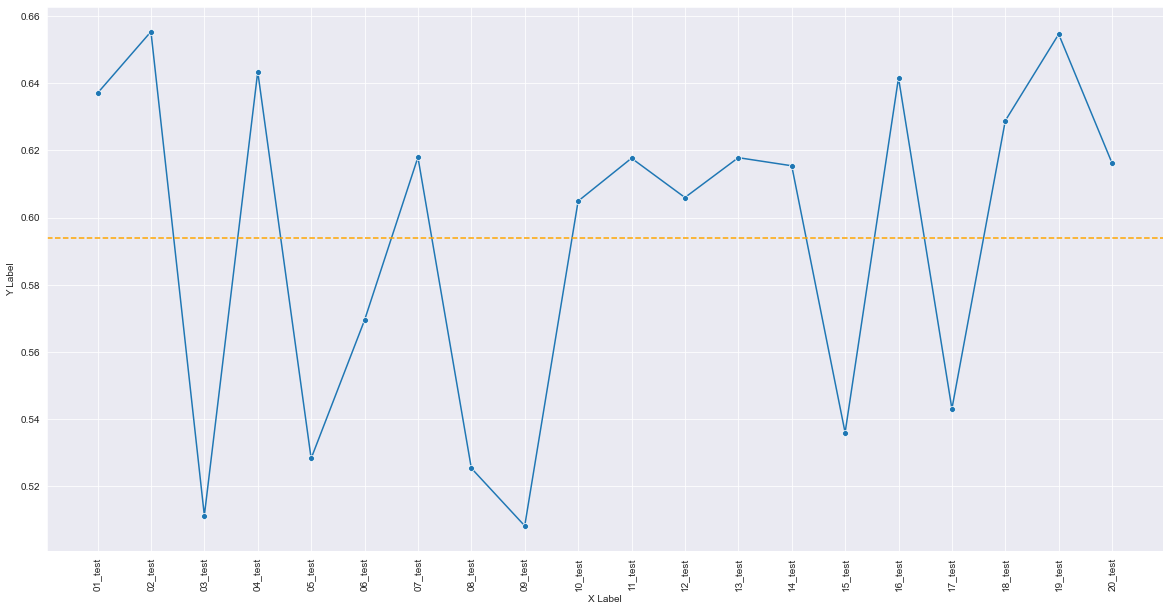

In [52]:
plt.figure(figsize=(20, 10))
sns.set_style("darkgrid")
ax = sns.lineplot(data=df, x="Image", y="Jaccard", marker = "o")
ax.axhline(df["Jaccard"].mean(), color="orange", linestyle="--")
ax.set(xlabel="X Label", ylabel = "Y Label")
plt.setp(ax.get_xticklabels(), rotation=90)


# Training Scores

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

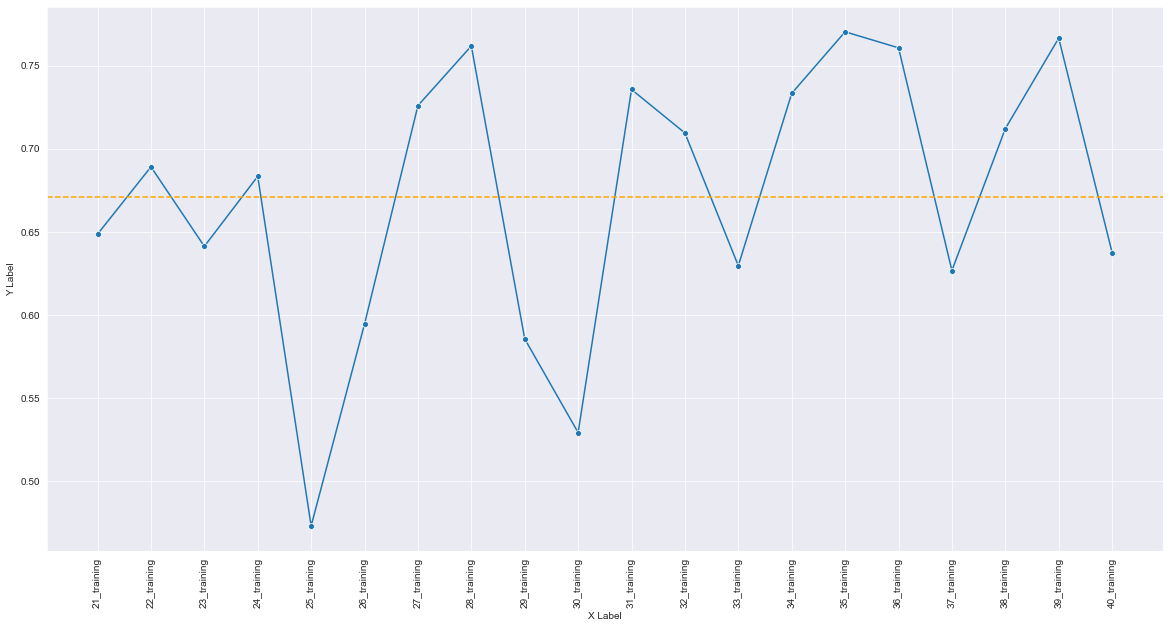

In [45]:
plt.figure(figsize=(20, 10))
sns.set_style("darkgrid")
ax = sns.lineplot(data=df, x="Image", y="Jaccard", marker = "o")
ax.axhline(df["Jaccard"].mean(), color="orange", linestyle="--")
ax.set(xlabel="X Label", ylabel = "Y Label")
plt.setp(ax.get_xticklabels(), rotation=90)
